In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scripts.implementations as lib  # Add personal library
import scripts.proj1_helpers as helper  # Add personal library

%matplotlib inline
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4)

DATA_FOLDER = 'data'
DATA_TRAIN = os.path.join(DATA_FOLDER, 'train.csv')
DATA_TEST = os.path.join(DATA_FOLDER, 'test.csv')

y, x, ids, header = helper.load_csv_data(DATA_TRAIN)
y_train, x_train,  y_validation, x_validation = lib.sep_valid_train_data(x,y,0.2);

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Data Cleaning 


## 1.1 Data Exploration

We first load the data to see what are the repartition of the data. In our case prediction gives `s` for signal and `b` for backgroud. In this case around 2/3 of the data (65.73%) are labeled as background.

In [8]:
print('Repartition of {} labels, s: {:.2f}%, b: {:.2f}%'.format(
    len(y_train), np.mean(y_train==1)*100, np.mean(y_train==-1)*100))

Repartition of 250000 labels, s: 34.27%, b: 65.73%


According to [the Higgs boson machine learning challenge](https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf) some variable are indicated as "may be undefined" when it can happen that they are meaning-
less or cannot be computed. In this case, their value is -999.0, which is outside the normal range of all variables. Let's put them to NaN so they will be easier to handle.

In [9]:
x_train[x_train == -999] = np.nan

Let's now take a look at the repartition of the NaN along the features. We can see that some features seems to have the same amount of NaN value. The second graph shows that some features seems to have NaNs values axactly at the same location.

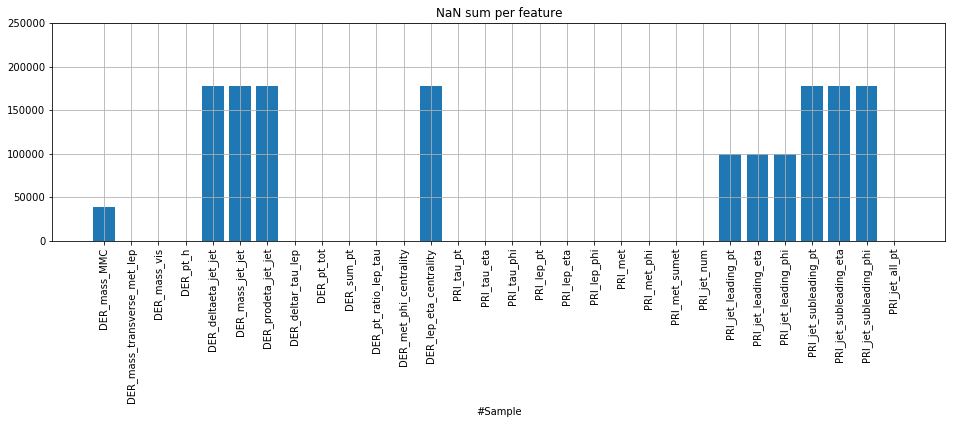

In [10]:
plt.figure(figsize=(16,4))
plt.bar(np.arange(len(header)), np.sum(np.isnan(x_train), axis=0))
plt.xticks(np.arange(len(header)), header, rotation='vertical')
plt.ylim(0, len(y_train)); plt.xlabel('Features'); plt.xlabel('#Sample'); plt.title('NaN sum per feature')
plt.grid(); plt.show();

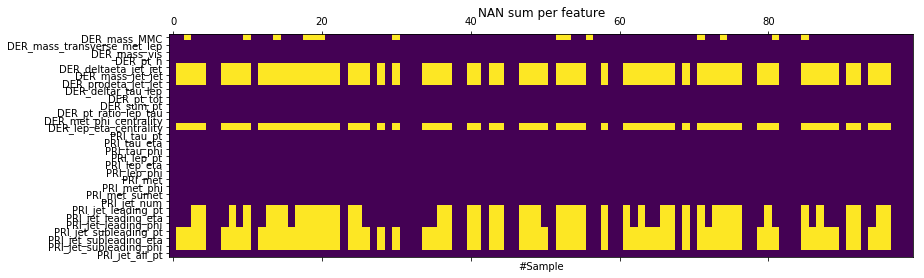

In [11]:
plt.figure(figsize=(14, 20))
plt.matshow(np.isnan(x_train)[:100, :].T)
plt.yticks(np.arange(len(header)), header)
plt.xlabel('Features'); plt.xlabel('#Sample'); plt.title('NAN sum per feature')
plt.show(); 

Does the NaN value gave us any information (`s` or `b`) ? We can see that is NaN is not present we are more likely to find a signal `s`. If NaN is present it seems that we are close to the initial distribution with 34%-66% ratio.

In [12]:
print('NaN is present, s: {:.2f}, b: {:.2f}'.format(
    np.mean(y_train[np.any(np.isnan(x_train), axis=1)] == 1), 
    np.mean(y_train[np.any(np.isnan(x_train), axis=1)] == -1)))
print('NaN is not present, s: {:.2f}, b: {:.2f}'.format(
    np.mean(y_train[~np.any(np.isnan(x_train), axis=1)] == 1), 
    np.mean(y_train[~np.any(np.isnan(x_train), axis=1)] == -1)))

NaN is present, s: 0.30, b: 0.70
NaN is not present, s: 0.47, b: 0.53


We can also take a look at the feature ranges. it can give us insights of the data. We can see that features (16), (19), (21), (26) and (29) are actually angles (range in $[-\pi, \pi]$). To be certain we checked it directly on the documentation. Note that we are ignoring the NaN values to compute the min and max.

We have to be careful with those results since the output gives us no imformation about the data distribution!

In [13]:
for i, feature in enumerate(x_train.T):
    print('Feature {} - {} has range: [{:.4f}, {:.4f}]'.format(
        i+1, header[i], np.nanmin(feature), np.nanmax(feature)))

Feature 1 - DER_mass_MMC has range: [9.0440, 1192.0260]
Feature 2 - DER_mass_transverse_met_lep has range: [0.0000, 690.0750]
Feature 3 - DER_mass_vis has range: [6.3290, 1349.3510]
Feature 4 - DER_pt_h has range: [0.0000, 2834.9990]
Feature 5 - DER_deltaeta_jet_jet has range: [0.0000, 8.5030]
Feature 6 - DER_mass_jet_jet has range: [13.6020, 4974.9790]
Feature 7 - DER_prodeta_jet_jet has range: [-18.0660, 16.6900]
Feature 8 - DER_deltar_tau_lep has range: [0.2080, 5.6840]
Feature 9 - DER_pt_tot has range: [0.0000, 2834.9990]
Feature 10 - DER_sum_pt has range: [46.1040, 1852.4620]
Feature 11 - DER_pt_ratio_lep_tau has range: [0.0470, 19.7730]
Feature 12 - DER_met_phi_centrality has range: [-1.4140, 1.4140]
Feature 13 - DER_lep_eta_centrality has range: [0.0000, 1.0000]
Feature 14 - PRI_tau_pt has range: [20.0000, 764.4080]
Feature 15 - PRI_tau_eta has range: [-2.4990, 2.4970]
Feature 16 - PRI_tau_phi has range: [-3.1420, 3.1420]
Feature 17 - PRI_lep_pt has range: [26.0000, 560.2710]
Fe

## 1.2 Data Cleaning - Naive

One solution to deal with NaN is to remove feature vectors that contains NaN values. After this we can normalize the data (0 mean and 1 standard deviation).

In [14]:
# Remove features with NaN
keep_id = np.nonzero(np.sum(np.isnan(x_train), axis=0) == 0)[0]
x_naive = x_train[:, keep_id]
# normalize features
x_naive = (x_naive - np.mean(x_naive, axis=0))/np.std(x_naive, axis=0)

In [15]:
from scripts.ml import cross_validation_ls

degrees = np.linspace(1, 6, 6).astype(int)
for i, degree in enumerate(degrees):
    acc, _, _ = cross_validation_ls(y_train, x_naive, degree=degree)
    print('{}/{} Least square deg {} with acc {:.4f}'.format(i+1, len(degrees), degree, acc))

1/6 Least square deg 1 with acc 0.7336
2/6 Least square deg 2 with acc 0.7536
3/6 Least square deg 3 with acc 0.7605
4/6 Least square deg 4 with acc 0.7632
5/6 Least square deg 5 with acc 0.6352
6/6 Least square deg 6 with acc 0.5558


## 1.3 Data Cleaning - Dealing with NaN


In [16]:
# normalize features
x_no_nan = x_train.copy()
x_no_nan = (x_no_nan - np.nanmean(x_no_nan, axis=0))/np.nanstd(x_no_nan, axis=0)
x_no_nan = np.nan_to_num(x_no_nan)
print('\nStd:', np.std(x_no_nan, axis=0))


Std: [ 0.9206  1.      1.      1.      0.5387  0.5387  0.5387  1.      1.      1.
  1.      1.      0.5387  1.      1.      1.      1.      1.      1.      1.
  1.      1.      1.      0.7748  0.7748  0.7748  0.5387  0.5387  0.5387
  1.    ]


In [18]:
for i, degree in enumerate(degrees):
    acc, _, _ = cross_validation_ls(y_train, x_no_nan, degree=degree)
    print('{}/{} Least square deg {} with acc {:.4f}'.format(i+1, len(degrees), degree, acc))

1/6 Least square deg 1 with acc 0.7445
2/6 Least square deg 2 with acc 0.7748
3/6 Least square deg 3 with acc 0.7854
4/6 Least square deg 4 with acc 0.6462
5/6 Least square deg 5 with acc 0.5287
6/6 Least square deg 6 with acc 0.6359


## 1.4 Feature augmentation

In [45]:
from scripts.ml import augmented_feat_angle

id_angle_feat = np.array([15])

print(np.shape(x_train))
x_aug = augmented_feat_angle(x_train, id_angle_feat)
print(np.shape(x_aug))

# normalize features
x_aug = (x_aug - np.nanmean(x_aug, axis=0))/np.nanstd(x_aug, axis=0)
x_aug = np.nan_to_num(x_aug)
print('\nStd:', np.std(x_aug, axis=0))

print(np.max(x_train[:, 15]))


(250000, 30)
(250000, 31)

Std: [ 0.9206  1.      1.      1.      0.5387  0.5387  0.5387  1.      1.      1.
  1.      1.      0.5387  1.      1.      1.      1.      1.      1.      1.
  1.      1.      0.7748  0.7748  0.7748  0.5387  0.5387  0.5387  1.      1.
  1.    ]
3.142


In [46]:
for i, degree in enumerate(degrees):
    acc, _, _ = cross_validation_ls(y_train, x_aug, degree=degree)
    print('{}/{} Least square deg {} with acc {:.4f}'.format(i+1, len(degrees), degree, acc))

1/6 Least square deg 1 with acc 0.7445
2/6 Least square deg 2 with acc 0.6557
3/6 Least square deg 3 with acc 0.6681
4/6 Least square deg 4 with acc 0.5330
5/6 Least square deg 5 with acc 0.5801
6/6 Least square deg 6 with acc 0.6023


In [ ]:
y_test, x_test, ids_test, header = helper.load_csv_data(DATA_TEST)

In [39]:
from scripts.implementations import build_poly, least_squares, accuracy
from scripts.proj1_helpers import create_csv_submission, predict_labels

x_test[x_test == -999] = np.nan

# normalize features
x_no_nan_t = x_test.copy()
x_no_nan_t = (x_no_nan_t - np.nanmean(x_no_nan_t, axis=0))/np.nanstd(x_no_nan_t, axis=0)
x_no_nan_t = np.nan_to_num(x_no_nan_t)
print('\nStd:', np.std(x_no_nan_t, axis=0))

xt =  build_poly(x_no_nan, 3)
xt_test =  build_poly(x_no_nan_t, 3)

loss, w = least_squares(y_train, xt)

y_pred_old = predict_labels(w, xt_test)
print(accuracy(y_train, xt.dot(w)))


Std: [ 0.9208  1.      1.      1.      0.5396  0.5396  0.5396  1.      1.      1.
  1.      1.      0.5396  1.      1.      1.      1.      1.      1.      1.
  1.      1.      1.      0.7744  0.7744  0.7744  0.5396  0.5396  0.5396
  1.    ]
0.785212


In [ ]:
from scripts.proj1_helpers import create_csv_submission

create_csv_submission(ids_test, y_pred, 'f.csv')
print('Results saved ...')

## 1.4 Data Cleaning - Dealing with physics

In [13]:
tags, count = np.unique(x_train[:, 22], return_counts=True)
print('Repartition of #jet {} along data {}%'.format(tags, 100*count/len(y_train)))

Repartition of #jet [ 0.  1.  2.  3.] along data [ 39.9652  31.0176  20.1516   8.8656]%


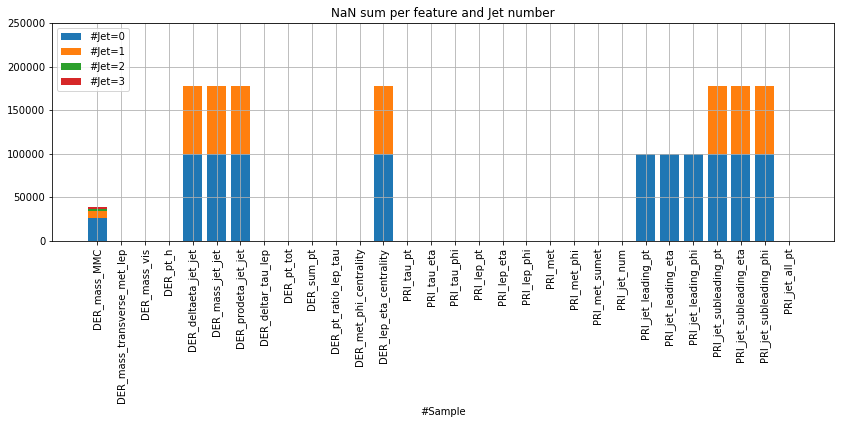

In [14]:
plt.figure(figsize=(14, 4))
nan_j = []
for i in range(4):
    nan_j.append(np.array([ np.sum(np.logical_and(x_train[:, 22] == i, np.isnan(f))) for f in x_train.T]))
    plt.bar(np.arange(len(header)), nan_j[-1], 
            label='#Jet={}'.format(i), bottom = np.sum(np.array(nan_j[:-1]), axis=0))
plt.xticks(np.arange(len(header)), header, rotation='vertical'); 
plt.ylim(0, len(y_train));
plt.xlabel('Features'); plt.xlabel('#Sample'); plt.title('NaN sum per feature and Jet number')
plt.legend(); plt.grid(); plt.show()

In [56]:
def get_data_jet(y, x, id_current_jet, id_jet=22):
    id_select = (x[:, id_jet] == id_current_jet)
    x_jet = x[id_select, :]
    y_jet = y[id_select]
    return id_select, y_jet, x_jet[:, np.logical_and(~np.any(np.isnan(x_jet), axis=0), np.arange(x.shape[1]) != id_jet)]
   
models = []
for i in range(4):
    _, y_train_j, x_train_j = get_data_jet(y_train, x_train, i)
    # Last vector is only 0's for #jet == 0, we remove it
    if i != 0:
        x_train_j = (x_train_j - np.mean(x_train_j, axis=0))/np.std(x_train_j, axis=0)
    else:
        x_train_j = (x_train_j[:, :-1] - np.mean(x_train_j[:, :-1], axis=0))/np.std(x_train_j[:, :-1], axis=0)
    models.append( {'y_train': y_train_j, 'x_train': x_train_j} )
    
len(models)


print()

0.0
0.0
0.0
0.0



In [70]:
for i in range(4):
    r = models[i]['y_train']
    rt = y_train[x_train[: ,22] == i]
    
    xt = x_train[x_train[: ,22] == i]
    xt = xt[:, np.logical_and(~np.any(np.isnan(xt), axis=0), np.arange(xt.shape[1]) != 22)]
    
    if i != 0:
        xt = (xt - np.mean(xt, axis=0))/np.std(xt, axis=0)
    else:
        xt = (xt[:, :-1] - np.mean(xt[:, :-1], axis=0))/np.std(xt[:, :-1], axis=0)
    
    print(np.linalg.norm(xt-models[i]['x_train']))
    print(np.sum(r - rt))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [16]:
degrees = np.linspace(1, 12, 12).astype(int)
best_acc = np.zeros(len(models))
for j, model in enumerate(models):
    acc = np.zeros(len(degrees))
    tr = np.zeros(len(degrees))
    te = np.zeros(len(degrees))
    for i, degree in enumerate(degrees):
        acc[i], tr[i], te[i] = cross_validation_ls(model['y_train'], model['x_train'], degree=degree)
        print('Jet-{}-{}: Least square max acc: {:.4f}, {:.4f}, {:.4f}'.format(
            j, degree, acc[i], tr[i], te[i]))
    best_acc[j] = np.max(acc)
    #print('Jet-{}: Least square max acc: {:.4f}, {:.4f}, {:.4f}, for deg: {}'.format(
    #    j, np.max(acc), tr[np.argmax(acc)], te[np.argmax(acc)], degrees[np.argmax(acc)]))
# Sum accuracy with the actual repartition of #jet over dataset
print('\n-> Theorical overal accuracy: {:.4f}'.format(np.sum(best_acc * count/len(y_train))))

Jet-0-1: Least square max acc: 0.8167, 0.5216, 0.5219
Jet-0-2: Least square max acc: 0.8233, 0.5061, 1.1778
Jet-0-3: Least square max acc: 0.8148, 0.5202, 6.9707
Jet-0-4: Least square max acc: 0.6803, 0.6382, 3226.1681
Jet-0-5: Least square max acc: 0.7676, 2.1161, 441100.7073
Jet-0-6: Least square max acc: 0.5228, 24.4187, 17575549.2150
Jet-0-7: Least square max acc: 0.6397, 4.8002, 637811984.3972
Jet-0-8: Least square max acc: 0.3772, 18.7339, 8666499565.8358
Jet-0-9: Least square max acc: 0.5711, 47.3909, 6251336494137.2158
Jet-0-10: Least square max acc: 0.5621, 7810.2005, 3025925272749596.0000
Jet-0-11: Least square max acc: 0.5143, 2467.0171, 1763301477402965760.0000
Jet-0-12: Least square max acc: 0.4893, 36793.8972, 323465073631512035328.0000
Jet-1-1: Least square max acc: 0.7104, 0.6105, 0.6107
Jet-1-2: Least square max acc: 0.7530, 0.5840, 0.5847
Jet-1-3: Least square max acc: 0.7593, 0.5785, 0.5831
Jet-1-4: Least square max acc: 0.7682, 0.5731, 0.5902
Jet-1-5: Least square m

# 2. Submission test

In [22]:
# Load both train and test data
y_train, x_train, ids_train, header = helper.load_csv_data(DATA_TRAIN)
y_test, x_test, ids_test, header = helper.load_csv_data(DATA_TEST)
x_train[x_train == -999] = np.nan
x_test[x_test == -999] = np.nan

In [23]:
tags, count = np.unique(x_train[:, 22], return_counts=True)
print('Repartition of #jet {} along train data {}%'.format(tags, 100*count/len(y_train)))
tags, count = np.unique(x_test[:, 22], return_counts=True)
print('Repartition of #jet {} along test data {}%'.format(tags, 100*count/len(y_test)))

Repartition of #jet [ 0.  1.  2.  3.] along train data [ 39.9652  31.0176  20.1516   8.8656]%
Repartition of #jet [ 0.  1.  2.  3.] along test data [ 40.0286  30.8564  20.1761   8.9389]%


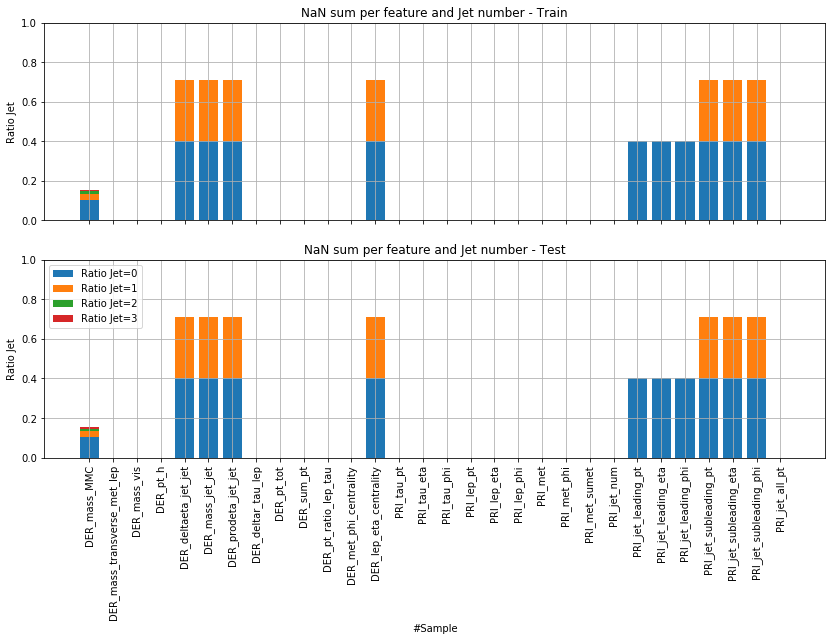

In [24]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(14, 8))
nan_j_tr = []; nan_j_te = []
for i in range(4):
    nan_j_tr.append(np.array([ np.sum(np.logical_and(x_train[:, 22] == i, np.isnan(f))) for f in x_train.T])/len(y_train))
    nan_j_te.append(np.array([ np.sum(np.logical_and(x_test[:, 22] == i, np.isnan(f))) for f in x_test.T])/len(y_test))
    axes[0].bar(np.arange(len(header)), nan_j_tr[-1], 
            label='Ratio Jet={}'.format(i), bottom = np.sum(np.array(nan_j_tr[:-1]), axis=0))
    axes[1].bar(np.arange(len(header)), nan_j_te[-1], 
            label='Ratio Jet={}'.format(i), bottom = np.sum(np.array(nan_j_te[:-1]), axis=0))
    
plt.xticks(np.arange(len(header)), header, rotation='vertical'); 
axes[0].set_ylim(0, 1); axes[0].set_ylabel('Ratio Jet'); axes[1].set_ylabel('Ratio Jet'); 
axes[0].grid(); axes[1].grid()
plt.xlabel('Features'); plt.xlabel('#Sample'); 
axes[0].set_title('NaN sum per feature and Jet number - Train')
axes[1].set_title('NaN sum per feature and Jet number - Test')
plt.legend(); plt.show()

In [30]:
models = []
for i in range(4):
    _, y_train_j, x_train_j = get_data_jet(y_train, x_train, i)
    id_test_j, _,  x_test_j = get_data_jet(y_test, x_test, i)
    # Last vector is only 0's for #jet == 0, we remove it
    if i != 0:
        x_train_j = (x_train_j - np.mean(x_train_j, axis=0))/np.std(x_train_j, axis=0)
        x_test_j = (x_test_j - np.mean(x_test_j, axis=0))/np.std(x_test_j, axis=0)
        #pass
    else:
        x_train_j = (x_train_j[:, :-1] - np.mean(x_train_j[:, :-1], axis=0))/np.std(x_train_j[:, :-1], axis=0)
        x_test_j = (x_test_j[:, :-1] - np.mean(x_test_j[:, :-1], axis=0))/np.std(x_test_j[:, :-1], axis=0)
    print(np.shape(y_train_j), np.shape(x_train_j), np.shape(y_test_j), np.shape(x_test_j))
    models.append( {'y_train': y_train_j, 'x_train': x_train_j, 
                    'x_test': x_test_j, 'id_test': id_test_j} )
    
sum_ = 0
for model in models:
    sum_ += np.sum(model['id_test'])
    
print(sum_, len(y_test))

(99913,) (99913, 17) (50794,) (227458, 17)
(77544,) (77544, 21) (50794,) (175338, 21)
(50379,) (50379, 28) (50794,) (114648, 28)
(22164,) (22164, 28) (50794,) (50794, 28)
568238 568238


In [35]:
from scripts.implementations import build_poly, least_squares, accuracy
from scripts.proj1_helpers import predict_labels

y_pred = np.zeros(len(y_test))
best_degrees = [1, 4, 5, 6]
for i, model in enumerate(models):
    
    _phi_train = build_poly(model['x_train'], best_degrees[i])
    _phi_test = build_poly(model['x_test'], best_degrees[i])
    loss, weights = least_squares(model['y_train'], _phi_train)
    
    y_pred_tmp = predict_labels(weights, _phi_test)
    y_pred[model['id_test']] = y_pred_tmp
    print(np.sum(y_pred == 0))
    print(accuracy(model['y_train'], _phi_train.dot(weights)))
    
print(np.sum(y_pred == 0))

340780
0.816870677489
165442
0.768428247189
50794
0.793941920245
0
0.787583468688
0


In [33]:
from scripts.proj1_helpers import create_csv_submission

create_csv_submission(ids_test, y_pred, 'f.csv')
print('Results saved ...')

Results saved ...


In [40]:
y_pred_old

array([-1., -1., -1., ...,  1., -1., -1.])

In [46]:
np.unique(x_test[y_pred==y_pred_old, 22], return_counts=True)

(array([ 0.,  1.,  2.,  3.]), array([213741,  85721,  84371,  37164]))

In [ ]:
0.4*0.81 + 0.6*0.65773

In [ ]:
sum_ = 0
for i in range(4):
    id_test_j, y_test_j, x_test_j = get_data_jet(y_test, x_test, i)
    # Last vector is only 0's for #jet == 0, we remove it
    if i != 0:
        x_test_j = (x_test_j - np.mean(x_test_j, axis=0))/np.std(x_test_j, axis=0)
    else:
        x_test_j = (x_test_j[:, :-1] - np.mean(x_test_j[:, :-1], axis=0))/np.std(x_test_j[:, :-1], axis=0)
    sum_ += np.sum(id_test_j)
    models[i]['id_test'] = id_test_j 
    models[i]['x_test'] = x_test_j
    
print(sum_, len(y_test))
print(np.nonzero(models[3]['id_test']))
print(np.nonzero(x_test[:, 22]==3))

In [ ]:
from scripts.implementations import build_poly, least_squares, accuracy
from scripts.proj1_helpers import predict_labels

y_pred = np.zeros(len(y_test))
best_degrees = [1, 4, 3, 4]

for i, model in enumerate(models):
    # Build polynomial matrix
    _phi_train = build_poly(model['x_train'], best_degrees[i])
    _phi_test = build_poly(model['x_test'], best_degrees[i])
    print(np.shape(model['x_train']), np.shape(model['x_test']))
    loss, weights = least_squares(model['y_train'], _phi_train)
    y_pred_tmp = predict_labels(weights, _phi_test)
    y_pred[model['id_test']] = y_pred_tmp
    print(accuracy(model['y_train'], _phi_train.dot(weights)))

In [ ]:
from scripts.proj1_helpers import create_csv_submission

create_csv_submission(ids, y_pred, 'submission.csv')
print('Results saved ...')

# 3. Model 
..... meeeeehhh

In [ ]:
from scripts.implementations import build_poly, least_squares, least_squares_GD, accuracy

xt =  build_poly(x, 3)
loss, w = least_squares(yb, xt)
print(loss, np.shape(w))
#loss, w = least_squares_GD(yb, xt, max_iters=700, loss_name='mae')
#print(loss)

print(np.shape(x))

In [ ]:
accuracy(yb, xt.dot(w))

In [ ]:
from scripts.ml import cross_validation_ls

_acc = []
_loss_tr = []
_loss_te = []

for degree in range(1,6):
    print('Least square, deg: {}'.format(degree))
    acc, loss_tr, loss_te = cross_validation_ls(yb, x, degree=degree)
    _acc.append(acc); _loss_te.append(loss_te), _loss_tr.append(loss_tr)

In [ ]:
plt.plot(_acc)

In [ ]:
from scripts.ml import cross_validation_ridge

_acc = []
_loss_tr = []
_loss_te = []

for degree in range(1,6):
    print('Ridge, deg: {}'.format(degree))
    acc, loss_tr, loss_te = cross_validation_ridge(yb, x, degree=degree)
    _acc.append(acc); _loss_te.append(loss_te), _loss_tr.append(loss_tr)

In [ ]:
plt.plot(_acc)